In [10]:
#onedrive = r"C:\Users\mikek\OneDrive"

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path

import shutil

#sys.path.append(os.path.join(onedrive,r"Project\python-packages\sdtools"))

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *

%load_ext autoreload
%autoreload 2


print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# Add core sources and transport barrier

Defining dimension z of size 1
>>> Field Nd+_src already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field Nd+_src to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc
>>> Field Pd+_src already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field Pd+_src to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc
>>> Field Pe_src already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field Pe_src to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc
>>> Field D_d+ already exists in /home/rg1114/Documents/PhD Proje

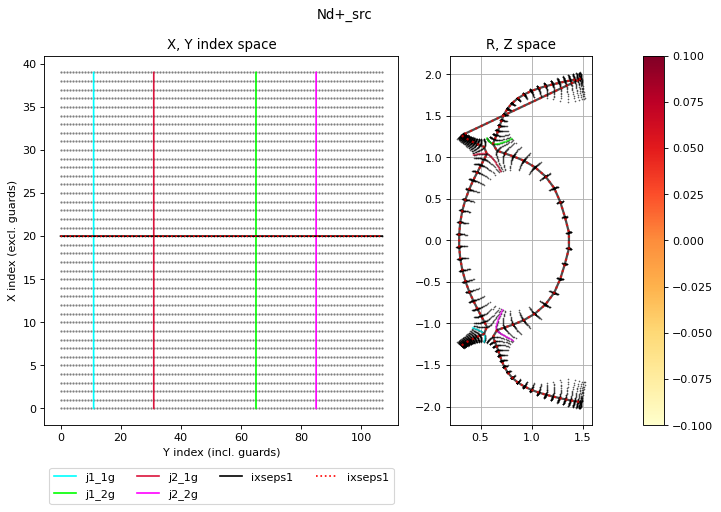

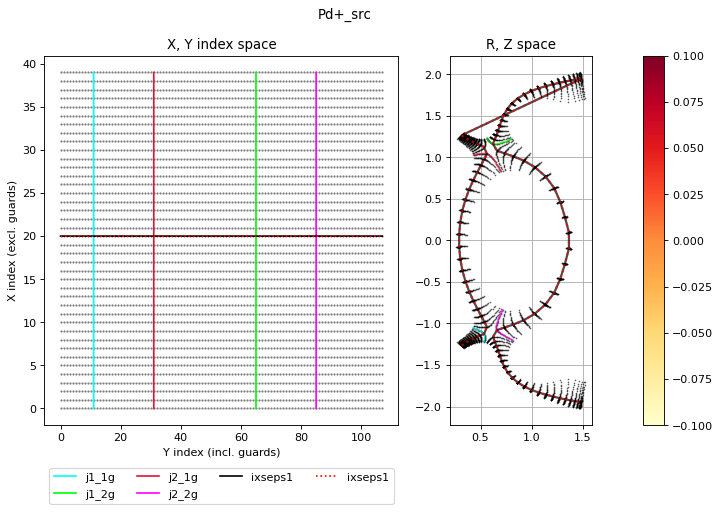

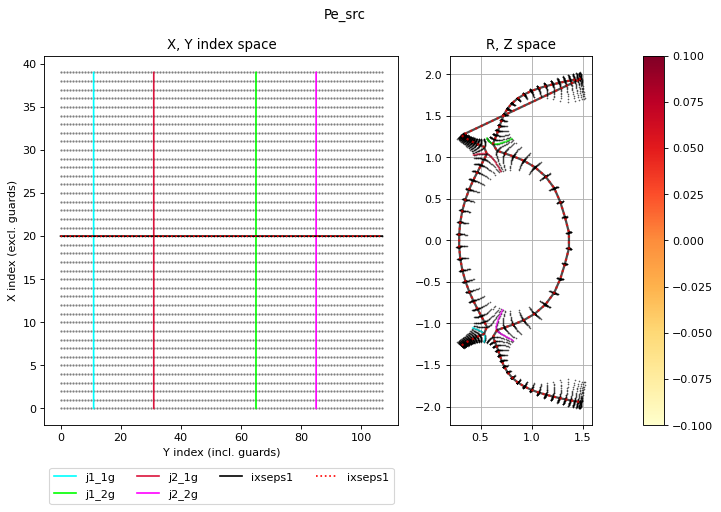

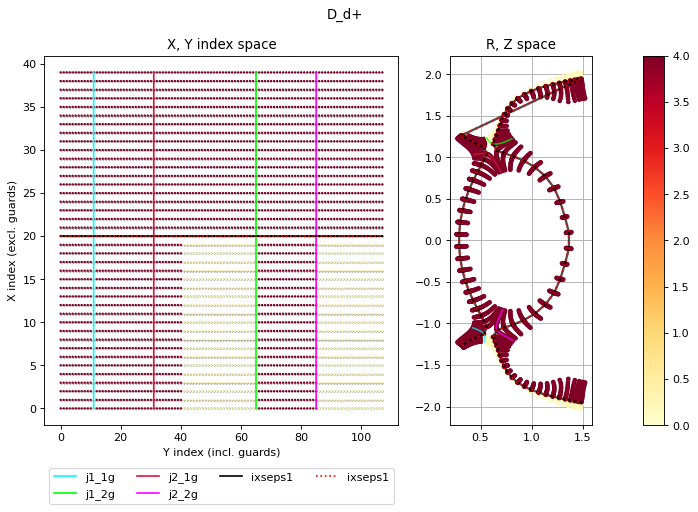

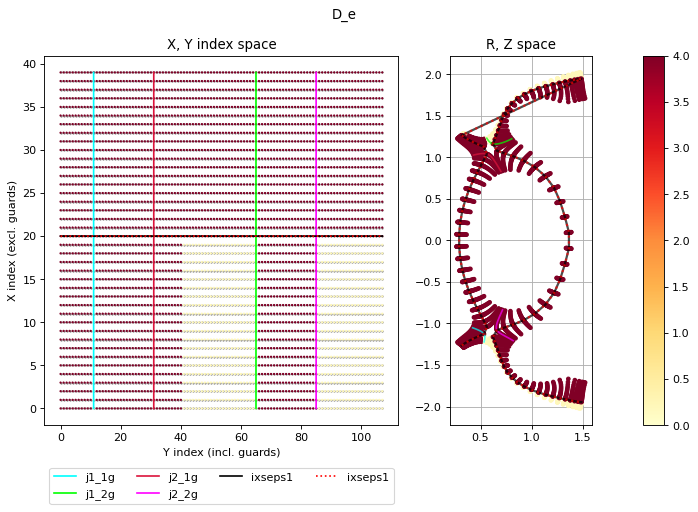

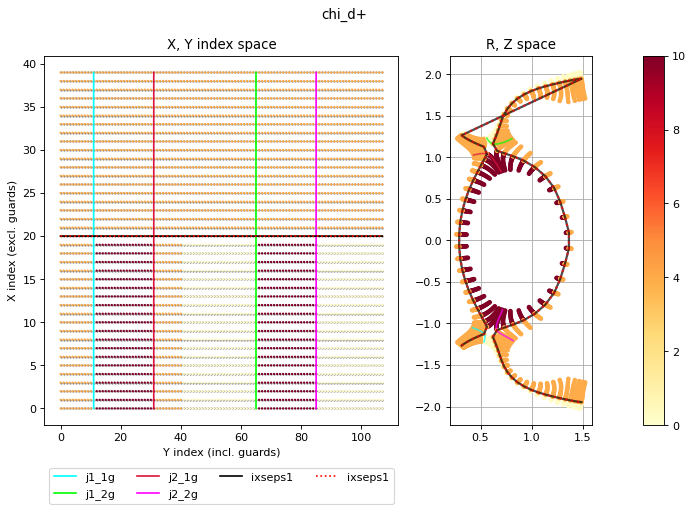

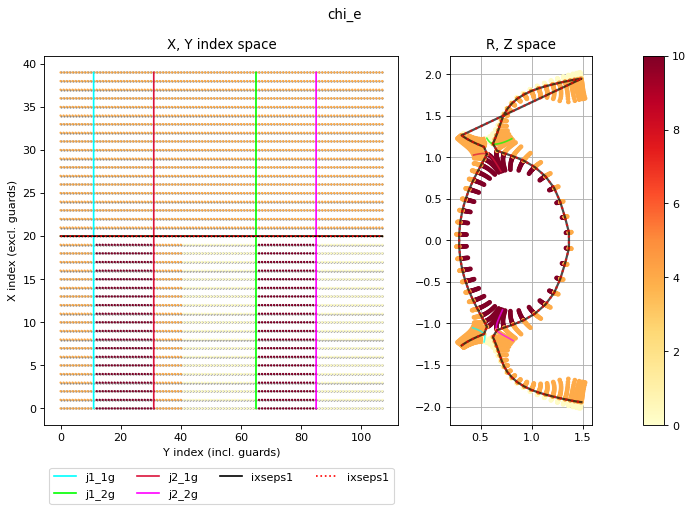

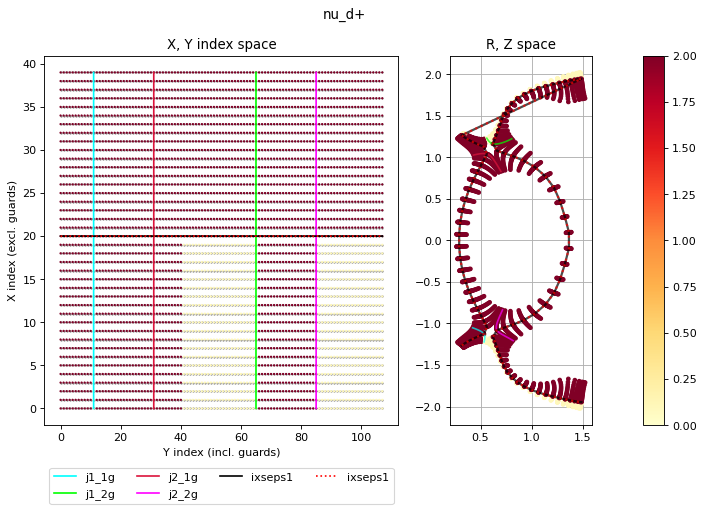

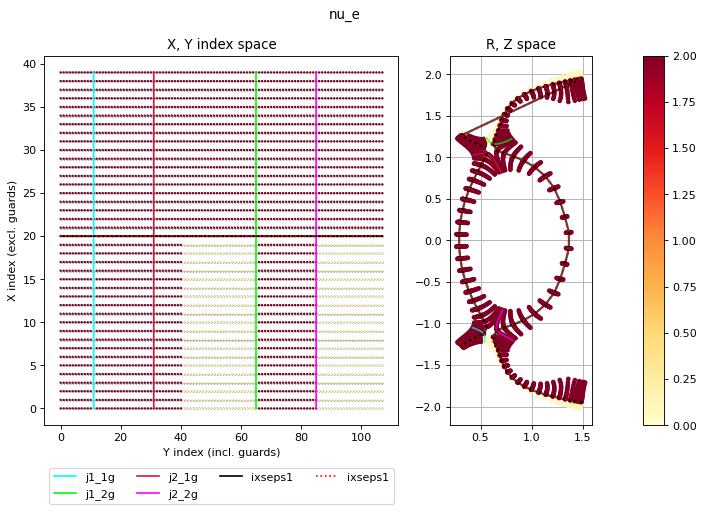

In [14]:
# close_mesh()
old_grid_path = r"/home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_2023.nc"
new_grid_path = r"/home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc"
impose_fields(
    old_grid_path,
    new_grid_path,
    Nd_src_puff = 0,   # s-1
    Pd_src_puff = 0,   # Pa of pressure
    Ni_src_core = 0,   # s-1 of particles
    Pi_src_core = 0,   # Pa of pressure
    Pe_src_core = 0,   # Pa of pressure

    D_core = 4,    # m2s-1
    D_sol  = 4,    # ms2s-1
    #D_pfr  = 0,    # m2s-1
    D_pfr_inner_upper = 4, # m2s-1
    D_pfr_inner_lower = 4, # m2s-1
    D_pfr_outer_upper = 0.2, # m2s-1
    D_pfr_outer_lower = 0.2, # m2s-1

    chi_core = 10,   # m2s-1
    chi_sol = 4,    # m2s-1
    #chi_pfr = 0,    # m2s-1
    chi_pfr_inner_upper = 4, # m2s-1
    chi_pfr_inner_lower = 4, # m2s-1
    chi_pfr_outer_upper = 0.2, # m2s-1
    chi_pfr_outer_lower = 0.2, # m2s-1

    nu_core = 2,    # m2s-1
    nu_sol = 2,     # m2s-1
    #nu_pfr = 0,     # m2s-1
    nu_pfr_inner_upper = 2, # m2s-1
    nu_pfr_inner_lower = 2, # m2s-1
    nu_pfr_outer_upper = 0.1, # m2s-1
    nu_pfr_outer_lower = 0.1, # m2s-1 
    
)

# Manually add puff and pump

Total flow: 0 [s-1]
Total flow per volume: 0.00e+00 [s-1 m-3]
Total heat source: 5.77e+02 [W]
Total heat source per volume: 1.08e+06 [W m-3]

>>> Field Nd_src already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field Nd_src to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc
>>> Field Pd_src already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field Pd_src to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc
>>> Field is_pump already exists in /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc, it will be overwritten
-> Wrote field is_pump to /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_

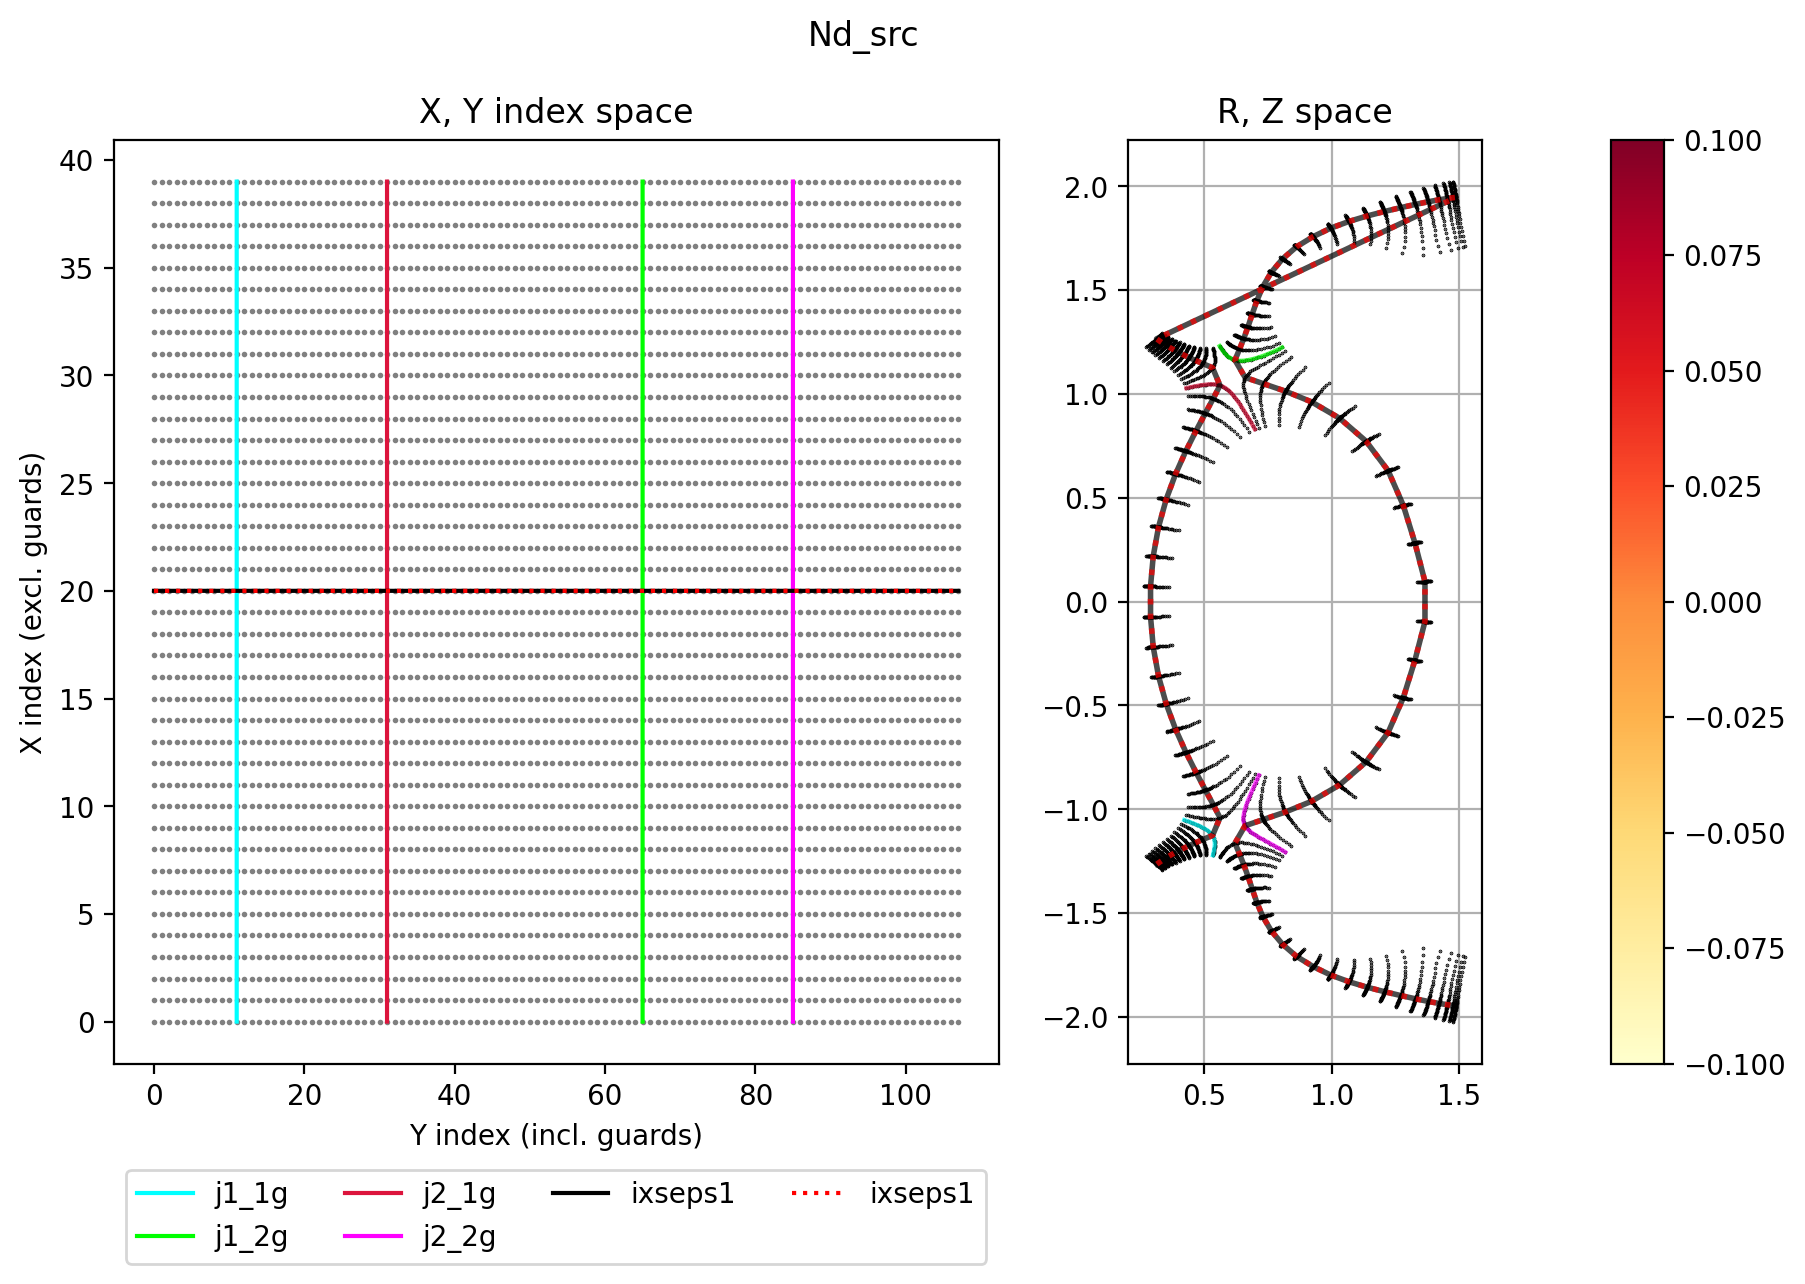

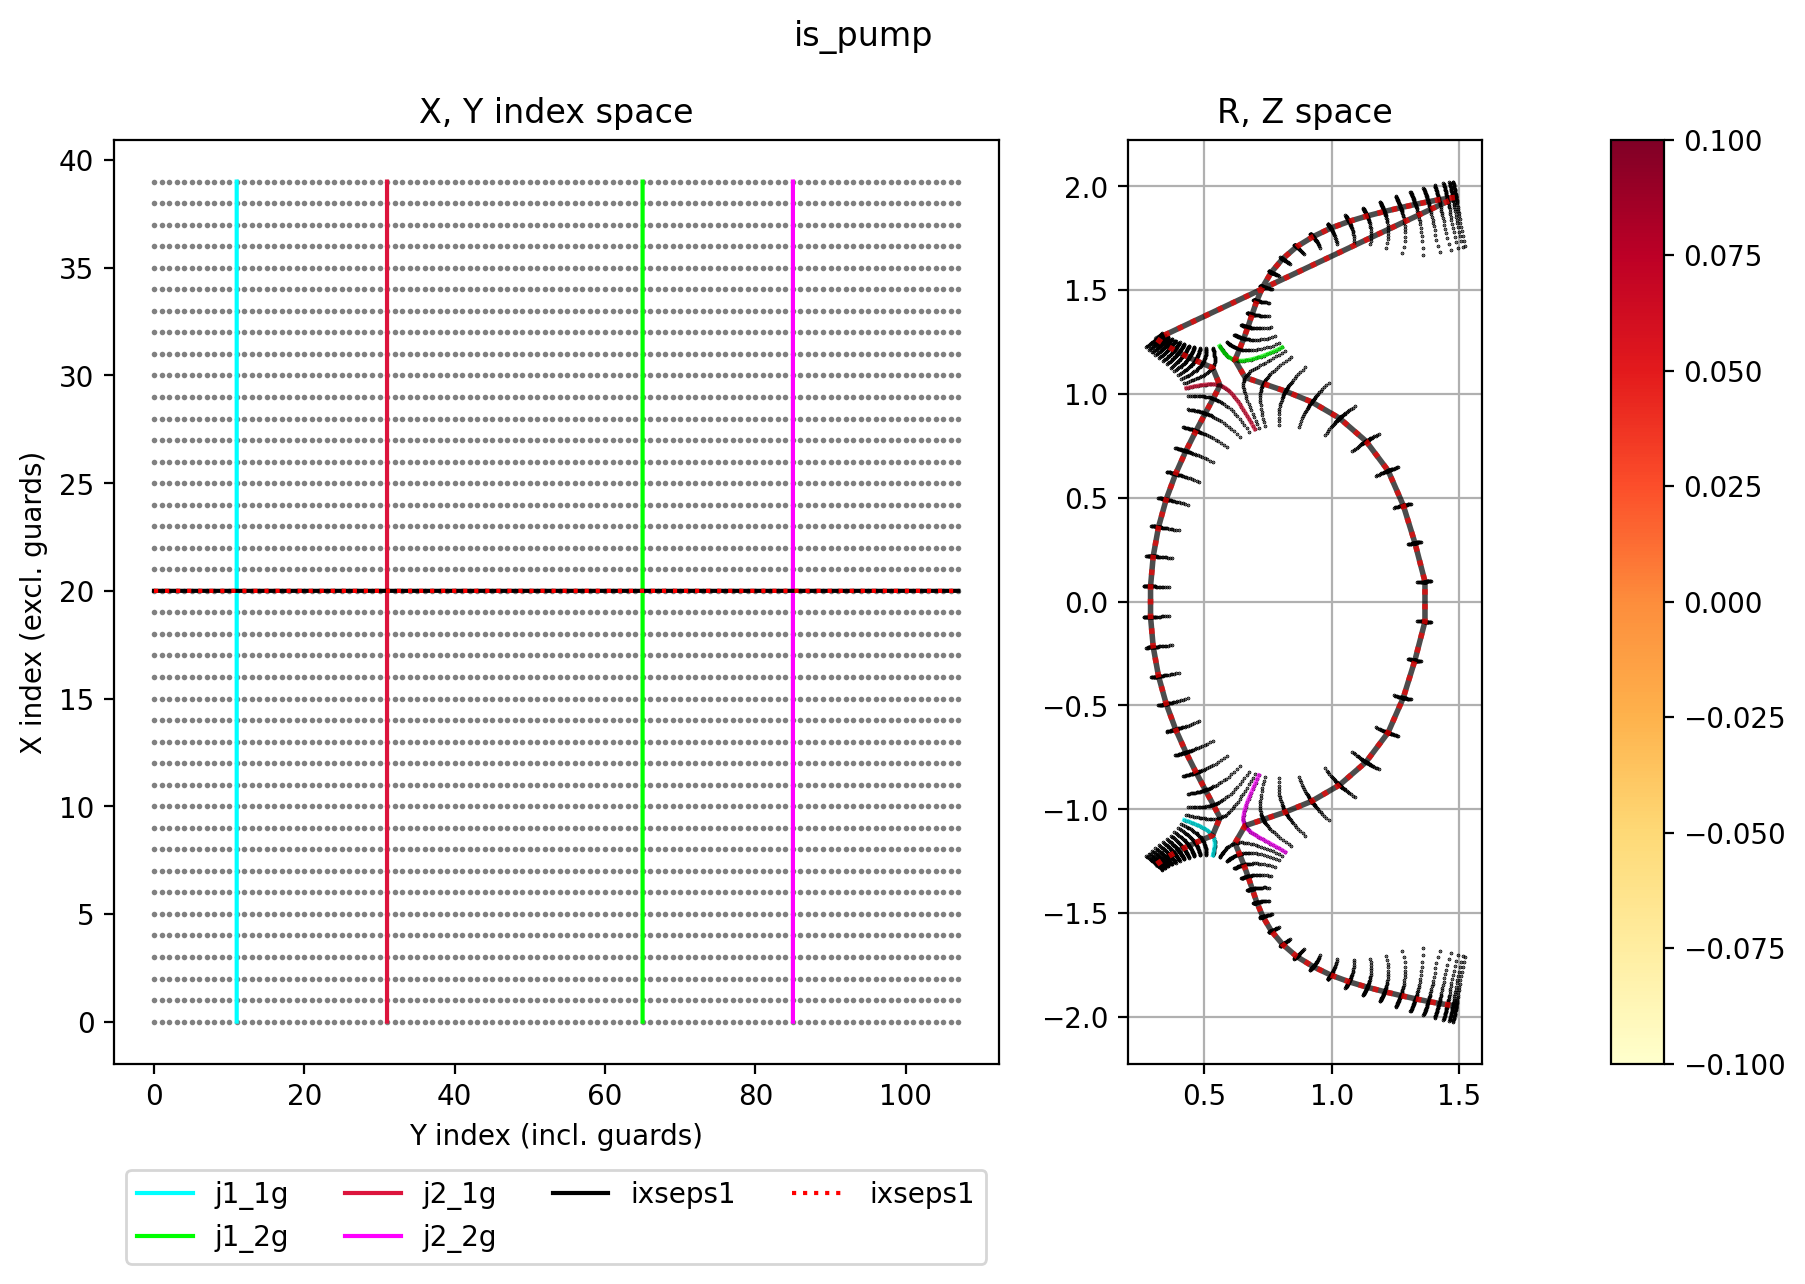

In [16]:
plt.close("all")
mesh = Mesh(new_grid_path)
self = mesh

# Inner Midplane selection
midplane_a = int((self.j1_1g - self.j2_1g) / 2) + self.j2_1g
midplane_b = int((self.j1_1g - self.j2_1g) / 2) + self.j2_1g + 1

# Outer Midplane selection
midplane_c = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g
midplane_d = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g + 1

#####################################################################################
# Finding the indicies related to all of the points in the inner most radial location in the core
# core_region_indices_inner = [0,1,2,3,4,5,6,7,8,9,10,11,12] 
# core_region_indices_outer = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  

# # Calculate the core region
# core_region = (-self.MXG-242, 
#             np.r_[
#                 [midplane_a-x for x in core_region_indices_inner],
#                 [midplane_b+x for x in core_region_indices_inner],
#                 [midplane_c-x for x in core_region_indices_outer],
#                 [midplane_d+x for x in core_region_indices_outer]
#                 ])

# print(core_region)
#####################################################################################

#####################################################################################
# Finding the points corresponding to the major and minor radii of the core
# radii_indices_outer = [0,15]   # SOLEDGE puff, coarse grid
# radii_indices_inner = [0]

# radii_selection =  (-self.MXG-242, 
#             np.r_[
#                 [midplane_b+x for x in radii_indices_inner],
#                 [midplane_d+x for x in radii_indices_outer],
#                 [midplane_d-x for x in radii_indices_outer],
#                 ])

#print(radii_selection)
#####################################################################################
# Adding the puff locations
puff_indices_outer = [0,15]   # SOLEDGE puff, coarse grid
puff_indices_inner = [0]

selection =  (-self.MXG+39, #-242 corresponds to the inner most radial point and +1 corresponds to the outermost point
            np.r_[
                [midplane_b+x for x in puff_indices_inner],
                [midplane_a+x for x in puff_indices_inner]
                ])
            
# selection = (-3, np.array(0))
# puff_region = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
puff_region = selection

# Check to see if the locations are where I want them to be since it may be hard to see on figure
# R_coordinate = mesh.mesh["Rxy"][puff_region]
# Z_coordinate = mesh.mesh["Zxy"][puff_region]
# print(f"The puff region is: {puff_region}")
# print(f"The R coordinates are: {R_coordinate} [m]")
# print(f"The Z coordinates are: {Z_coordinate} [m]")




mesh.mesh["dv"] = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi
volume = mesh.mesh["dv"][puff_region]

total_flow = 0   # atoms per second

total_flow_per_volume = total_flow * (volume/volume.sum()) / volume  # first find how much per cell, then per volume
print(f"Total flow: {total_flow} [s-1]")
print(f"Total flow per volume: {total_flow_per_volume.sum():.2e} [s-1 m-3]")

heat_source = 1.2e21 * 3 * constants("q_e")  #  3eV per particle (assume dissociated molecules)
heat_source_per_volume = heat_source * (volume/volume.sum()) / volume 
print(f"Total heat source: {heat_source:.2e} [W]")
print(f"Total heat source per volume: {heat_source_per_volume.sum():.2e} [W m-3]")

#####################################################################################
# Modifying the Pump Region
# pump_indicies_outer = list(range(37, -38, -1))
# pump_indicies_inner = list(range(37, -38, -1))

# pump_region = (-self.MXG+1, 
#             np.r_[
#                 [midplane_d+x for x in pump_indicies_outer],
#                 [midplane_b+x for x in pump_indicies_outer]
#                 ])


# Routine to ensure that the pump location is where you wnat it to be
# R_coordinate_pump = mesh.mesh["Rxy"][pump_region]
# Z_coordinate_pump = mesh.mesh["Zxy"][pump_region]
# print(f"Pump region is: {pump_region}")
# print(f"The pump R-coordinates are: {R_coordinate_pump}")
# print(f"The pump Z-coordinates are: {Z_coordinate_pump}")
#####################################################################################

#####################################################################################
# Highlighting the PFR
# pfr_indicies_outer = list(range(37, 15, -1)) + list(range(-38, -16, 1)) 
# pfr_indicies_inner = list(range(21, 11, -1)) + list(range(-21, -12, 1))

# pfr_selection = (np.r_[-self.MXG - 242: -self.MXG - 179],
#                  np.r_[
#                      [midplane_b + x for x in pfr_indicies_inner],
#                      [midplane_d + x for x in pfr_indicies_outer]
#                  ])

# pfr_region = pfr_selection
# pfr_region_xindex = pfr_region[0]
# pfr_region_yindex = pfr_region[1]
# First_point = [pfr_region_xindex[0], pfr_region_yindex]
# Create a list to store all points
#all_points = [[x, pfr_region_yindex] for x in pfr_region_xindex]

#print(all_points)

# print(f"The pfr region is: {pfr_region}")
# print(f"The x-indices are: {pfr_region_xindex}")
# print(f"The y-indices are: {pfr_region_yindex}")
# print(f"The first point is: {First_point}")

#####################################################################################

Pd_src = Field("Pd_src", mesh)
Nd_src = Field("Nd_src", mesh)
is_pump = Field("is_pump", mesh)

# sol_edge = self.slices("sol_edge")
inner_sol_edge = self.slices("inner_sol_edge")
outer_sol_edge = self.slices("outer_sol_edge")
low_pfr = self.slices("lower_pfr_edge")
upper_pfr = self.slices("upper_pfr_edge")
inner_upper_target_guard = self.slices("inner_upper_target_guard")
inner_lower_target_guard = self.slices("inner_lower_target_guard")
outer_upper_target_guard = self.slices("outer_upper_target_guard")
outer_lower_target_guard = self.slices("outer_lower_target_guard")



# is_pump.data[inner_sol_edge] = 1
# is_pump.data[outer_sol_edge] = 1
# is_pump.data[low_pfr] = 1
# is_pump.data[upper_pfr] = 1 
# is_pump.data[inner_upper_target_guard] = 1
# is_pump.data[inner_lower_target_guard] = 1
# is_pump.data[outer_upper_target_guard] = 1
# is_pump.data[outer_lower_target_guard] = 1
print()

Nd_src.data[puff_region] = total_flow_per_volume
Pd_src.data[puff_region] = heat_source_per_volume
mesh.write_field(Nd_src)
mesh.write_field(Pd_src)

# is_pump.data[pump_region] = 1 # Add pump rate here *Ask Mike 
Nd_src.plot(dpi = 200)
is_pump.plot(dpi = 200)


mesh.write_field(is_pump, dtype = "Field2D")

try:
    mesh.close()
    del mesh
except:
    pass

Total pressure source: 0.00e+00 [W]
Pressure source per volume: 0.00e+00 [W m-3]
Total density source: 0.00e+00 [s-1]
Density source per volume: 0.00e+00 [s-1 m-3]
Mesh file /home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc closed


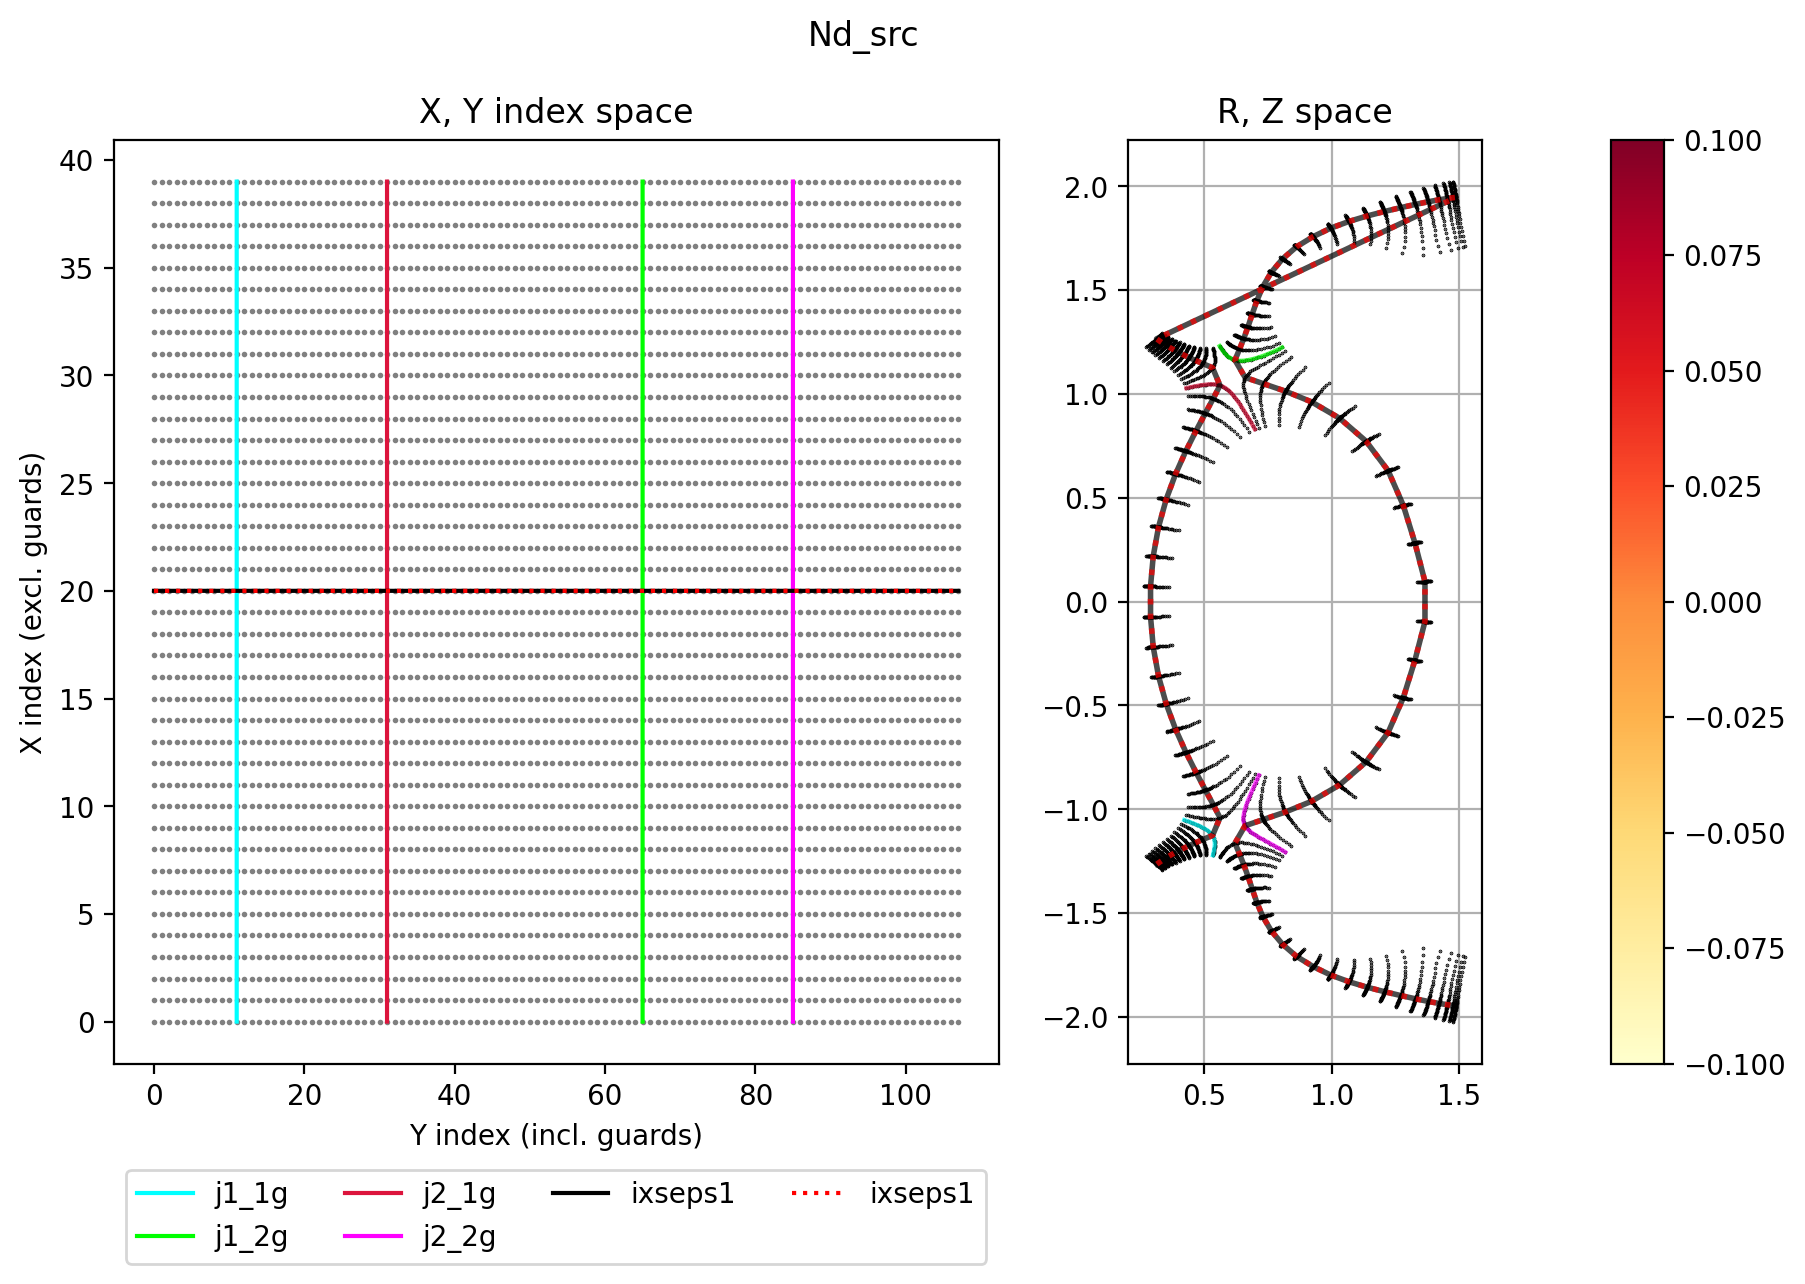

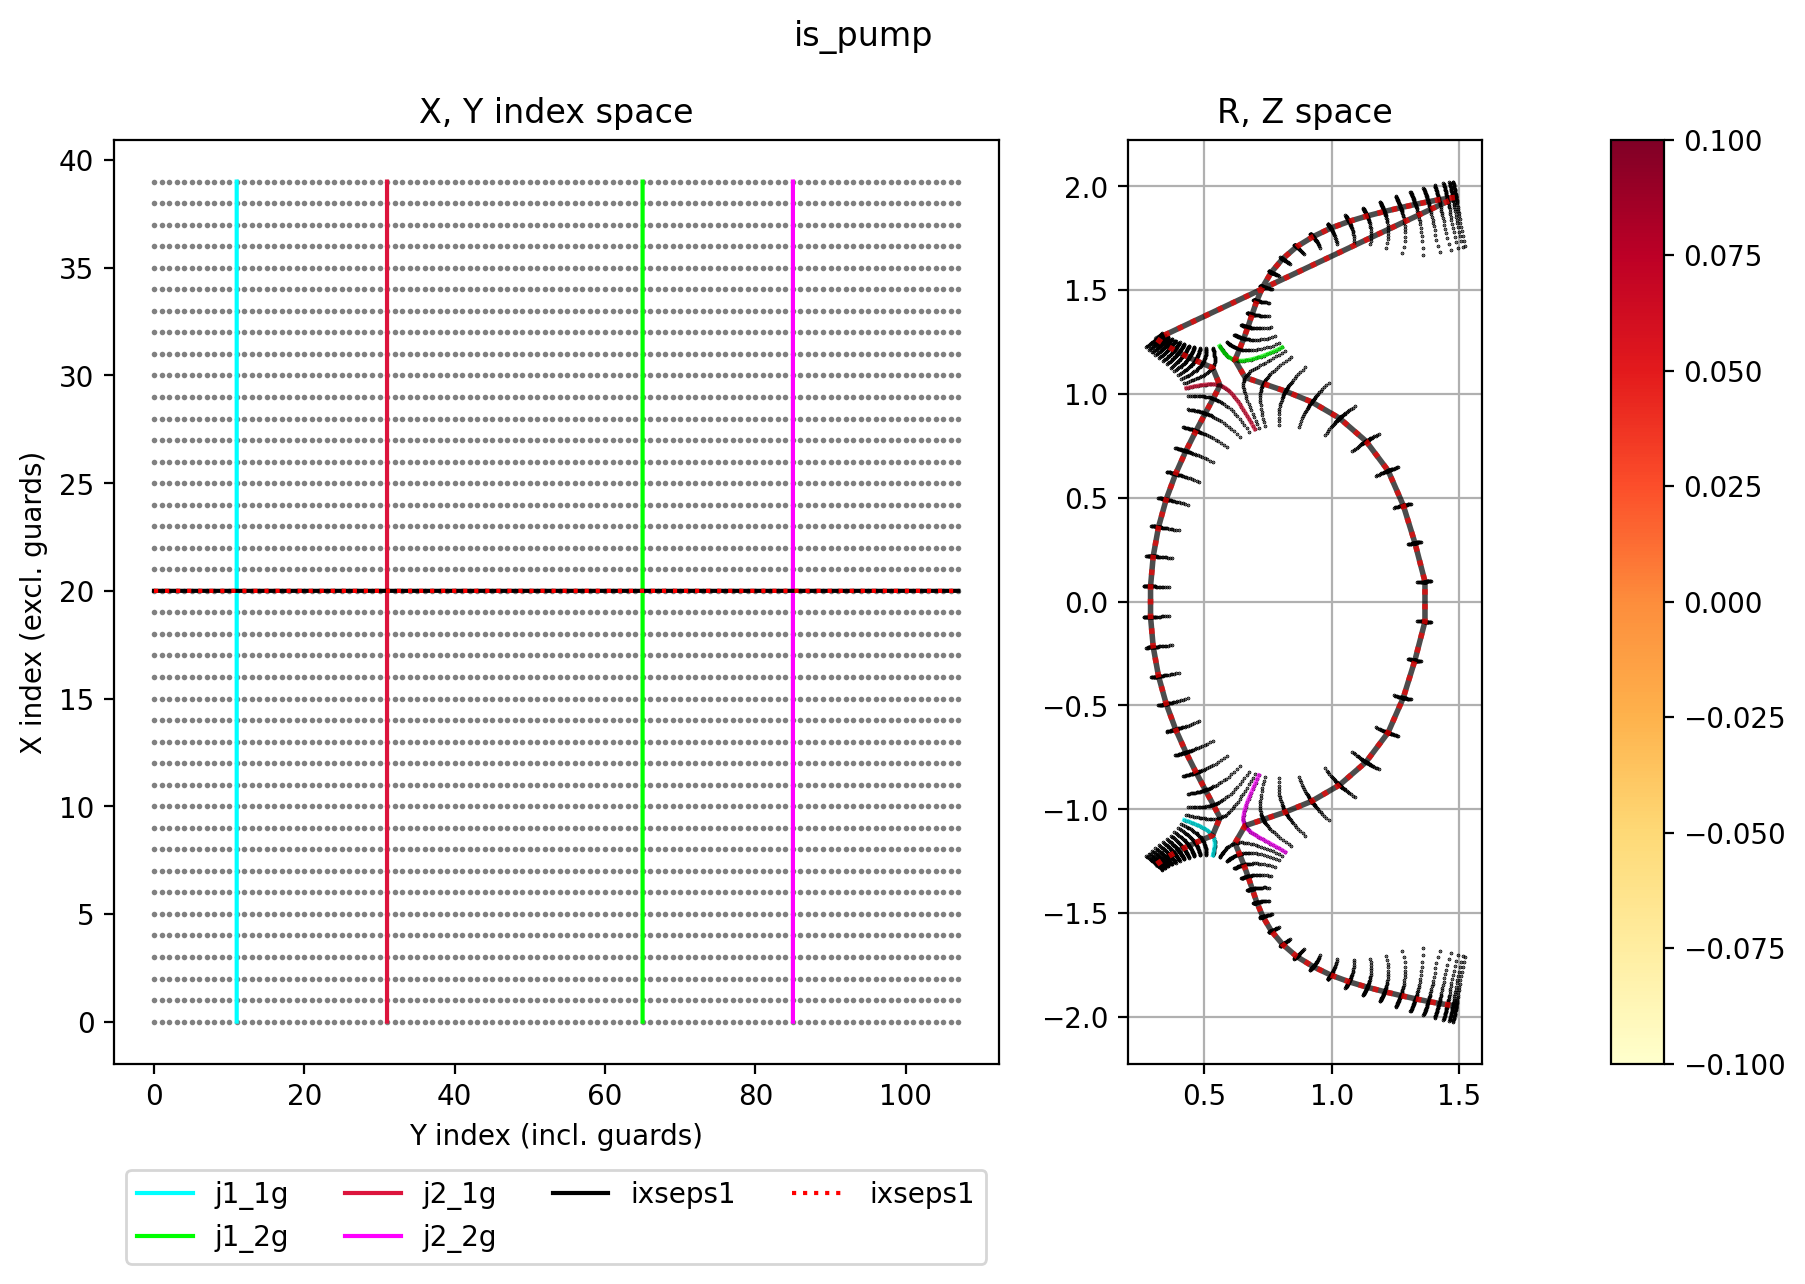

In [17]:
try:
    mesh.close()
    del mesh
except:
    pass

mesh = Mesh(r"/home/rg1114/Documents/PhD Project/Hermes-3/Collab_project_mike_lloyd/Grids/Moulton_lowres_modified_2023.nc")

pressure_source_per_volume = mesh.mesh["Pe_src"].squeeze()
density_source_per_volume = mesh.mesh["Nd_src"].squeeze()


dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

pressure_source = (pressure_source_per_volume * dv).sum()
density_source = (density_source_per_volume * dv).sum()

##############################################################################
# Finding the volume of a thin strip in the core.
# The thin strip corresponds to points placed in the inner most radial location in the core

# Calculate the total volume of all the selected cells# Calculate the total volume of all the selected cells
# core_volume = (dv[core_region]).sum()
# total_volume = dv.sum()
# print(f"The volume of the thin strip in the core is: {core_volume:.2e} [m3]")
# print(f"The total volume of plasma (excluding core) is: {total_volume:.2e} [m3]")
##############################################################################

##############################################################################
# Finding the total volume of the core

# Calculate the volume within the core region
# radii_minor = mesh.mesh["Rxy"][radii_selection]
# radii_major = mesh.mesh["Zxy"][radii_selection]
# minor_radius = radii_minor[1] - radii_minor[0]
# major_radius = radii_major[4] - radii_major[2]
# length = radii_minor[2]*2*np.pi
# surface_area = major_radius*minor_radius*np.pi
# total_core_volume = surface_area*length

# Printing the results
#print(f"The radii are: {radii} [m]")
#print(f"The minor radius is: {minor_radius} [m3]")
#print(f"The minor radius is: {major_radius} [m3]")
# print(f"The volume of the core is: {total_core_volume:.2e} [m3]")
##############################################################################

print(f"Total pressure source: {pressure_source:.2e} [W]")
print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [W m-3]")
print(f"Total density source: {density_source:.2e} [s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [s-1 m-3]")

# Plotting the Puff and Pump regions
Nd_src.plot(dpi = 200)
is_pump.plot(dpi = 200)

try:
    mesh.close()
    del mesh
except:
    pass